# PBR_TECAN_CC
   
   Visualize cell-counts data and then tried to create a regression using the measurements from exp2 and exp3, the later part didn't work out

# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import scipy

import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

from os.path import join as pjoin

import itertools as it

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

In [2]:
pd.options.display.max_rows = 100

# Helper Function

In [3]:
def get_wavelen_df(df, wavelen='680'):
    """This function returns a df which can be merged
    with temp df append the measurements"""
    
    tdf = df[df['wavelen']==wavelen].copy()
    
    tdf = tdf.drop(labels='wavelen', axis=1)
    
    tdf = tdf.rename({i:i+wavelen for i in xp2.columns}, axis=1)
    
    
    return tdf

In [4]:
def get_wav_ks(df, regressor='560'):
    
    return df.loc[regressor].values


def get_predictions(df, coef_list, regressor='560'):
    """
    This function uses the coefficients obtained from the simple linear and Beer-Lambert's law
    to make predictions. Each prediction is composed of either the [bacterial] or [chlamy] 
    fraction of the regressor signal. Ensure that you're using the coefficient dictionary for 
    the proper regressand wavelengths, and take note of
    """
    
    tdf = df.copy()
    tmp = pd.DataFrame()
    
    # columns
    cols = tdf.columns.values
    
    
    
    """Application of a680_a720 & a680_730 models to A680 & A730 measurements
    There are no A720 measurements in the Tecan-measure Exp data"""
    
    # coefficients for 680_720 models
    kB1, kC1, kB2, kC2 = coef_list[0]
    
    # colum names from exp2 data
    yT1, yT2 = cols[0:2:1]
    
    # checking columns
    #print(yT1, yT2)
    
    # tube and model naming scheme
    B = yT1[0:2]+'B_p680_720_'+regressor
    C = yT1[0:2]+'C_p680_720_'+regressor
    
    
    # predictions
    tmp[B] = (kC2*tdf[yT1] - kC1*tdf[yT2]) / (-kC1*kB2 + kC2*kB1)
    tmp[C] = (kB2*tdf[yT1] - kB1*tdf[yT2]) / (-kB1*kC2 + kB2*kC1)

    
    # coefficients for 680_730 models
    kB1, kC1, kB2, kC2 = coef_list[1]
    
    
    # tube and model naming scheme
    B = yT1[0:2]+'B_p'+yT1[2:]+'_'+yT2[2:]+'_'+regressor
    C = yT1[0:2]+'C_p'+yT1[2:]+'_'+yT2[2:]+'_'+regressor
    
    

    tmp[B] = (kC2*tdf[yT1] - kC1*tdf[yT2]) / (-kC1*kB2 + kC2*kB1)
    tmp[C] = (kB2*tdf[yT1] - kB1*tdf[yT2]) / (-kB1*kC2 + kB2*kC1)
    
    """ END of this application """
    
    # coefficients for 680_750 models
    kB1, kC1, kB2, kC2 = coef_list[2]
    yT1, yT2 = cols[0:3:2]
    #print(yT1, yT2)
    
    # tube and model naming scheme
    B = yT1[0:2]+'B_p'+yT1[2:]+'_'+yT2[2:]+'_'+regressor
    C = yT1[0:2]+'C_p'+yT1[2:]+'_'+yT2[2:]+'_'+regressor
    
    # predictions
    tmp[B] = (kC2*tdf[yT1] - kC1*tdf[yT2]) / (-kC1*kB2 + kC2*kB1)
    tmp[C] = (kB2*tdf[yT1] - kB1*tdf[yT2]) / (-kB1*kC2 + kB2*kC1)
    

    
    return tmp.copy()



def model_to_tecan_data(tec_df, coef_dfs, regressor='560'):
    """ Set-up function for applying the models"""
    
    tgen = tec_df.columns.values.reshape(8,3)

    # obtain relevant regressor coefs from the table of model coefficients
    coef_list = []
    for cos in coef_dfs:
        coef_list.append(get_wav_ks(cos, regressor))
    
    mdf = tec_df.copy()
    
    #print(coef_list)
    for tubes in tgen:
        mdf = mdf.join(get_predictions(tec_df[tubes], coef_list, regressor=regressor))

    return mdf.copy()

# Tecan'd PBR Exp Data + Pre-Process

In [5]:
# Tecan'd Exp2 & 3 Data are 

In [6]:
# Import Tecan PBR Exp2 & 3 Data Daily Sample's Tecan measurements
pbr_path = '../data_o/pbr'
fx2 = 'exp2/tecan_scan/exp2_tecaned_daily.csv'
fx3 = 'exp3/tecan_scan/exp3_tecaned_daily.csv'

# Pre-process
xp2 = pd.read_csv(pjoin(pbr_path,fx2))
xp3 = pd.read_csv(pjoin(pbr_path,fx3))

xp2['date_time'] = pd.to_datetime(xp2['date_time'], format='%d.%m.%Y %H:%M:%S').dt.round('5min')
xp3['date_time'] = pd.to_datetime(xp3['date_time'], format='%d.%m.%Y %H:%M:%S').dt.round('5min')


xp2['wavelen'] = xp2['wavelen'].astype(str)
xp3['wavelen'] = xp3['wavelen'].astype(str)


xp2 = xp2.set_index(keys='date_time', drop=True)
xp3 = xp3.set_index(keys='date_time', drop=True)

# pivot the data and rename the columns accordingly
xp2 = xp2.pivot(columns='wavelen', values=xp2.columns[1:])
xp2.columns = [''.join(col) for col in xp2.columns.values]

xp3 = xp3.pivot(columns='wavelen', values=xp3.columns[1:])
xp3.columns = [''.join(col) for col in xp3.columns.values]


In [7]:

# Apply MODELS to Tecan Data --- this allows you to obtain the
    # fraction that is B and C
    # fraction that is B and C
    
    # It is with the Fractions that you can then try and correlate with the actuall cell count data

# Save PBR Tecan'd Data

In [8]:
path='../data_o/pbr/pbr_exp_preprocessed'

# xp2.to_csv(pjoin(path,'tecaned_pbr_exp2_daily_samples.csv'))
# xp3.to_csv(pjoin(path,'tecaned_pbr_exp3_daily_samples.csv'))

# Cell Count Data + Pre-Process

In [9]:
# Import Cell Count Data

    # Segregate Exp2 & 3 and obtain an average and stdev on a per day per tube basis
    # Segregate each of the two experiments by cell type
    # for each cell type [b, c] in each of two segregated experiments get mean and stdev
    

In [10]:
# Entire cell count data
path = '../data_o/pbr'
fname = 'all_pbr_cell_counter_results.csv'

ccdf = pd.read_csv(pjoin(path,fname), parse_dates=['cc_sampling_time'])

# some coulter CC data is denoted as 0, this should be handled as pd.nan instead
# as there were some problems with the data collection at that time. This is because
# nan ensures that the value is ignored when taking the mean rather than it being
# included otherwise
ccdf.loc[ccdf['Sample_concentration']==0, 'Sample_concentration'] = np.nan

# ensure completeness
ccdf.info()

pd.options.display.max_rows = 15

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 7 columns):
experiment              2120 non-null int64
sampling_day            2120 non-null int64
pbr_tube                2120 non-null int64
Sample_concentration    2104 non-null float64
cc_sampling_time        2120 non-null datetime64[ns]
Filename                2120 non-null object
type_of_cell            2120 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 116.0+ KB


In [11]:
# While all PBR Samples have coulter cell count data only ex3 and ex4 samples were tecan-measured
# therefore we will use these values to correlate against the predicted fractions of the tecan data

# Segregation of Data & Pre-processing
# main group by object
gb = ccdf.groupby(by='experiment')

# rename columns
rn = {'Sample_concentration':'concentration',
      'cc_sampling_time':'date_time', 
      'type_of_cell':'cell_type'}

# drop labels
dl = ['experiment', 'Filename']

# sort by
sr = ['sampling_day', 'pbr_tube']

# grab relevant dataframes: exp2 and 3
ccdfx2 = gb.get_group(2).reset_index(drop=True).drop(labels=dl,axis=1).rename(rn, axis=1).sort_values(by=sr)
ccdfx3 = gb.get_group(3).reset_index(drop=True).drop(labels=dl,axis=1).rename(rn, axis=1).sort_values(by=sr)

# changing the datetimes for each day to a single value for all tubes since it only matters
# when they were extracted from the pbr itself oLL that given day
for sd in ccdfx2['sampling_day'].unique():
    dt = ccdfx2[(ccdfx2['sampling_day']==sd) & (ccdfx2['pbr_tube']==1)]['date_time'].values[0]
    ccdfx2.loc[ccdfx2['sampling_day']==sd,'date_time'] = dt

    
# Mean & Standard Deviation Calculation and DF reformatting

    
# Exp2 Cell Count
# regroup by cell type to further segregate and the get means and stdev
x2gb = ccdfx2.groupby(by='cell_type')
cell_counts_x2 = []
for name, group in x2gb:
    name
    cell_counts_x2.append(group.drop(labels=['cell_type'], axis=1))
    

x2_cell_counts = []
for df in cell_counts_x2:
    tdf = df.groupby(['sampling_day', 'pbr_tube'], as_index=False).agg({'concentration':['mean', 'std'],'date_time':'last'})
    tdf.columns = ['sampling_day', 'pbr_tube', 'conc_mean', 'conc_std', 'date_time']
    tdf = tdf.sort_values(by=['sampling_day', 'pbr_tube'])
    tdf = tdf.set_index('date_time')
    x2_cell_counts.append(tdf)

    tdf.head()

for sd in ccdfx3['sampling_day'].unique():
    dt = ccdfx3[(ccdfx3['sampling_day']==sd) & (ccdfx3['pbr_tube']==1)]['date_time'].values[0]
    ccdfx3.loc[ccdfx3['sampling_day']==sd,'date_time'] = dt

    
# Exp3 Cell Counts 
x3gb = ccdfx3.groupby(by='cell_type')
cell_counts_x3 = []
for name, group in x3gb:
    name
    cell_counts_x3.append(group.drop(labels=['cell_type'], axis=1))

# Mean & Standard Deviation Calculation and DF reformatting
x3_cell_counts = []
for df in cell_counts_x3:
    tdf = df.groupby(['sampling_day', 'pbr_tube'], as_index=False).agg({'concentration':['mean', 'std'],'date_time':'first'})
    tdf.columns = ['sampling_day', 'pbr_tube', 'conc_mean', 'conc_std', 'date_time']
    tdf = tdf.sort_values(by=['sampling_day', 'pbr_tube'])
    tdf = tdf.set_index('date_time')
    x3_cell_counts.append(tdf)
    
    #tdf.info()
    tdf.head()

'b'

'c'

,sampling_day,pbr_tube,conc_mean,conc_std
date_time,,,,
2019-04-17 19:42:00,0,1,2.429613e+06,9.347595e+05
2019-04-17 19:42:00,0,2,2.237978e+06,5.233150e+05
2019-04-17 19:42:00,0,3,2.691604e+06,NaN
2019-04-17 19:42:00,0,4,3.887649e+06,3.383603e+05
2019-04-17 19:42:00,0,5,3.643749e+06,1.378778e+06


,sampling_day,pbr_tube,conc_mean,conc_std
date_time,,,,
2019-04-17 19:42:00,0,1,108548.62120,13926.794580
2019-04-17 19:42:00,0,2,163492.98500,45232.314518
2019-04-17 19:42:00,0,3,174883.88970,NaN
2019-04-17 19:42:00,0,4,310569.66625,37337.058411
2019-04-17 19:42:00,0,5,331006.28940,107451.134540


'b'

'c'

,sampling_day,pbr_tube,conc_mean,conc_std
date_time,,,,
2019-05-11 17:12:00,0,1,6.533019e+05,21320.962832
2019-05-11 17:12:00,0,2,1.155842e+06,92390.839316
2019-05-11 17:12:00,0,3,1.047796e+06,31981.444107
2019-05-11 17:12:00,0,4,9.146226e+05,113711.801653
2019-05-11 17:12:00,0,5,7.764242e+05,67516.382207


,sampling_day,pbr_tube,conc_mean,conc_std
date_time,,,,
2019-05-11 17:12:00,0,1,120609.57910,21320.962832
2019-05-11 17:12:00,0,2,160812.77215,14213.975198
2019-05-11 17:12:00,0,3,185939.76785,35534.938030
2019-05-11 17:12:00,0,4,165838.17130,28427.950396
2019-05-11 17:12:00,0,5,178401.66910,31981.444248


In [12]:
# check that date_time count matches sampling_day counts
# and that they're in order

#ccdfx2['date_time'].dt.round('D').unique()
#ccdfx2['sampling_day'].unique()



# Cell Counts Visualize

    Looking at the following graphs there are some obvious outliers, I would get rid of them:
        Exp2:
            12th day of Tube 8, Give it the measure of the average of all the tubes including itself
        
        Exp3:
            8th day of Tube 7, Give it the measure of the average of all the tubes including itself
            
            
    Once you've done this you can start correlating against the predicted values. Then you would have
    about how to do the regressions from these absorbance to cc counts. <<--- no longer necessary,
    because we have CC and Abs data from the same experiment

(0, 600000000.0)

(0, 1500000.0)

(0, 1500000.0)

Text(0.5, 1.05, 'Exp2 & 3 Bacteria and Chlamydomonas Cell Counts')

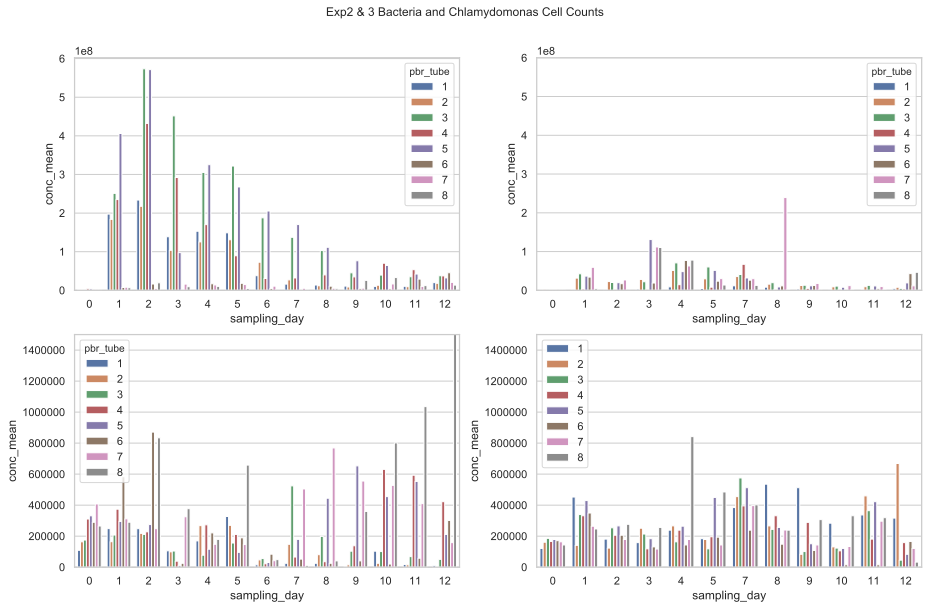

In [13]:
ccdfs = [x2_cell_counts[0], x2_cell_counts[1], x3_cell_counts[0], x3_cell_counts[1]]

fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(13,8))

sns.barplot(data=ccdfs[0], y='conc_mean',x='sampling_day', hue='pbr_tube', ax=ax[0][0])
ax[0][1].set_ylim(bottom=0, top=6e8)

sns.barplot(data=ccdfs[1], y='conc_mean',x='sampling_day', hue='pbr_tube', ax=ax[1][0])
ax[1][0].set_ylim(bottom=0, top=1.5e6)

sns.barplot(data=ccdfs[2], y='conc_mean',x='sampling_day', hue='pbr_tube', ax=ax[0][1])

sns.barplot(data=ccdfs[3], y='conc_mean',x='sampling_day', hue='pbr_tube', ax=ax[1][1])
ax[1][1].set_ylim(bottom=0, top=1.5e6)

plt.suptitle("Exp2 & 3 Bacteria and Chlamydomonas Cell Counts", y=1.05)
plt.tight_layout()
plt.legend()
# Note: Tube 8 for Day 12 has a much higher cell count than all other tubes, (~3e6)
# but for better comparison we'll change the uppter limit on the y-axi to 800K 

# Model B|C Fractions against Cell count data
    
    In order to get fractions, first apply the models to the Tecan Data
    e.g. T1680 * T1720 || T1680 * T1750 || T1680 * T1730
    
    Note that the Tecan-measured samples were measured using 730 and not 720. Although not the same these wavelengths as the ones measure by the PBR, they are similar enough in their regression fractions that we can compare them...
    
    # model a720, a730 and average them?

# Community Models

In [14]:
# Import Community Models
    #[x] establish that the models are behaving properly given that they behave significantly 
    #different from the original single strain models
path = "../data_o/calibration/community_calibration/created_models"

a680_a720 = pd.read_csv(pjoin(path,'a680_a720_coefficients.csv'), index_col=0)
a680_730  = pd.read_csv(pjoin(path,'a680_730_coefficients.csv'), index_col=0)
a680_a750 = pd.read_csv(pjoin(path,'a680_a750_coefficients.csv'), index_col=0)

In [15]:
# all the previously calculated model coefficients are loaded
# to a list which allows one later to choose a different
# regressor. As we have noted not all the wavelengths are 
# behaving like expected, e.g. A600 data, REVIST A600
rel_models = [a680_a720, a680_730, a680_a750]
for df in rel_models:
    df.head(2)



,kB680,kC680,kB720,kC720
A600,0.877526,1.617013,0.814493,0.816399
500,0.739568,1.003908,0.686166,0.505954


,kB680,kC680,kB730,kC730
A600,0.877526,1.617013,0.756929,0.796985
500,0.739568,1.003908,0.639104,0.495227


,kB680,kC680,kB750,kC750
A600,0.877526,1.617013,0.768603,0.761013
500,0.739568,1.003908,0.647349,0.471613


### Apply Models to Tecan-measure PBR Samples

    # We Will Use 560 as the regressor wavelength, but in reality any wavelength can be used
    # to regress back to and obtain rations
    
    # Two models are used a680_730 and a680_750 which both regress back to '560'
    # However we're only interested in the '730' models

In [16]:
# Using the models to  regress back to 560 B and C signal partitions
tec_x2_partitions = model_to_tecan_data(xp2, rel_models, regressor='560')
tec_x3_partitions = model_to_tecan_data(xp3, rel_models, regressor='560')

# Save Modeled Data

In [17]:
# path = '/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data_o/pbr/pbr_modeled_output_data'

# tec_x2_partitions.to_csv(pjoin(path,'tec_measd_exp2_modeled_output.csv'))
# tec_x3_partitions.to_csv(pjoin(path,'tec_measd_exp3_modeled_output.csv'))

In [18]:
# save this data 
# load in TecPbrComp
# extract dates from pbr
# apply mode to pbr
# compare

In [19]:
# Segregate the A680_A730 signal partitions for each experiment

In [20]:
# These are the relevant columns we need to compare against the Cell Counter Data
[i for i in tec_x3_partitions.columns.values[24:] if 'B' in i and '720' in i]
[i for i in tec_x3_partitions.columns.values[24:] if 'B' in i and '730' in i]
[i for i in tec_x3_partitions.columns.values[24:] if 'C' in i and '730' in i]

['T1B_p680_720_560',
 'T2B_p680_720_560',
 'T3B_p680_720_560',
 'T4B_p680_720_560',
 'T5B_p680_720_560',
 'T6B_p680_720_560',
 'T7B_p680_720_560',
 'T8B_p680_720_560']

['T1B_p680_730_560',
 'T2B_p680_730_560',
 'T3B_p680_730_560',
 'T4B_p680_730_560',
 'T5B_p680_730_560',
 'T6B_p680_730_560',
 'T7B_p680_730_560',
 'T8B_p680_730_560']

['T1C_p680_730_560',
 'T2C_p680_730_560',
 'T3C_p680_730_560',
 'T4C_p680_730_560',
 'T5C_p680_730_560',
 'T6C_p680_730_560',
 'T7C_p680_730_560',
 'T8C_p680_730_560']

In [21]:
#tec_x3_partitions

### Exp2 B & C Predicted 560 Partitions

    Note: We don't know the TRUE 560 Measurements, so we don't know how close our predictions are to 'Truth' but  according to our models the they have fairly good predictive power.
    Its also impossible to know how well each partition truly belong to either chlamy or bacteria. What we do know is that our models say that our prediction of Chlamy is really,
    good, which would mean that our bacteria fraction is also good, but the model doesn't show this.... 
    
    NOTE: The values of the predicted C partitions are very low and sometimes negative... this will be a problem during the regression, the best we can do here take note of the cell counts
    which are NOT ENOUGH to induce a good enough signal at '680', this will be because the chalmy are too diluted at those levels in the tubes.

# Visualisation

In [22]:
x2_B_p = tec_x2_partitions[[i for i in tec_x2_partitions.columns.values[24:] if 'B' in i and '730' in i]]
x2_C_p = tec_x2_partitions[[i for i in tec_x2_partitions.columns.values[24:] if 'C' in i and '730' in i]]

In [23]:
x3_B_p = tec_x3_partitions[[i for i in tec_x3_partitions.columns.values[24:] if 'B' in i and '730' in i]]
x3_C_p = tec_x3_partitions[[i for i in tec_x3_partitions.columns.values[24:] if 'C' in i and '730' in i]]

# Cell Count & Respective Predicted Values
    
    The bargraphs below show how the Coulter CC measured values look against the actual predicted values.
    What we're hoping to see are semi-identical bargraphs with the difference being the y-units. However
    we expect that we would see some overlap, but this is not the case

In [24]:
%config InteractiveShell.ast_node_interactivity='none'

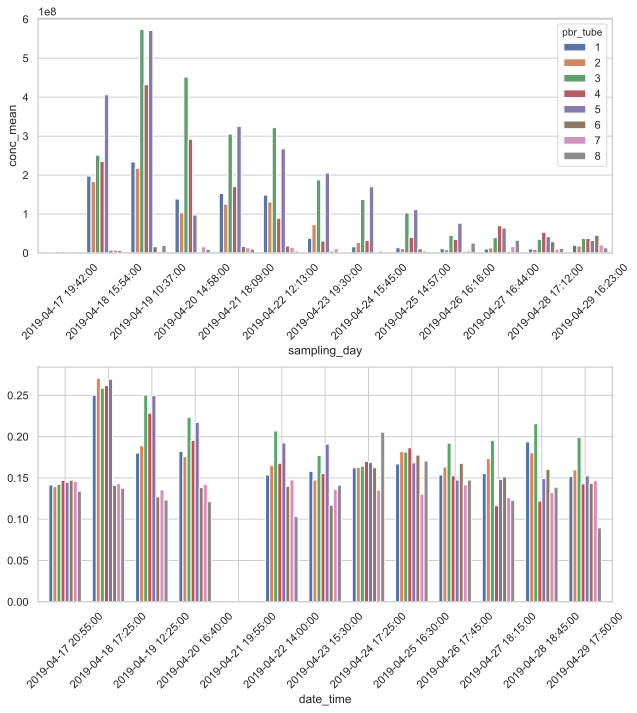

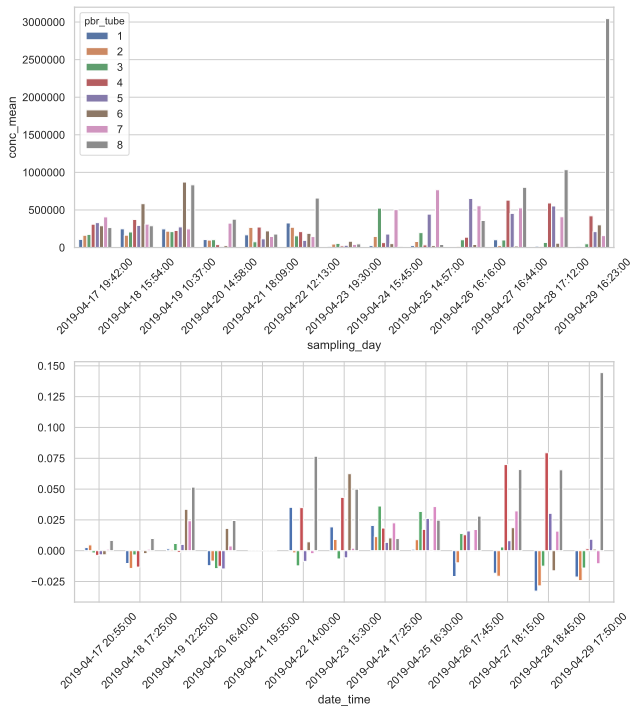

In [25]:
fs = (9, 10)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=fs)

sns.barplot(data=x2_cell_counts[0], y='conc_mean', x='sampling_day', hue='pbr_tube', ax=ax[0])
ax[0].set_xticklabels(x2_cell_counts[0].index.unique(), rotation=45)

x2_B_p.plot(kind='bar', style='.', width=0.75, ax=ax[1], legend=False)
ax[1].set_xticklabels(labels=x2_B_p.index,rotation=45)
plt.tight_layout()



fig, ax = plt.subplots(nrows=2, ncols=1, figsize=fs)

sns.barplot(data=x2_cell_counts[1], y='conc_mean', x='sampling_day', hue='pbr_tube', ax=ax[0])
ax[0].set_xticklabels(x2_cell_counts[1].index.unique(), rotation=45)

x2_C_p.plot(kind='bar', legend=False, style='.', width=0.7, ax=ax[1])
ax[1].set_xticklabels(labels=x2_C_p.index,rotation=45)


plt.tight_layout()

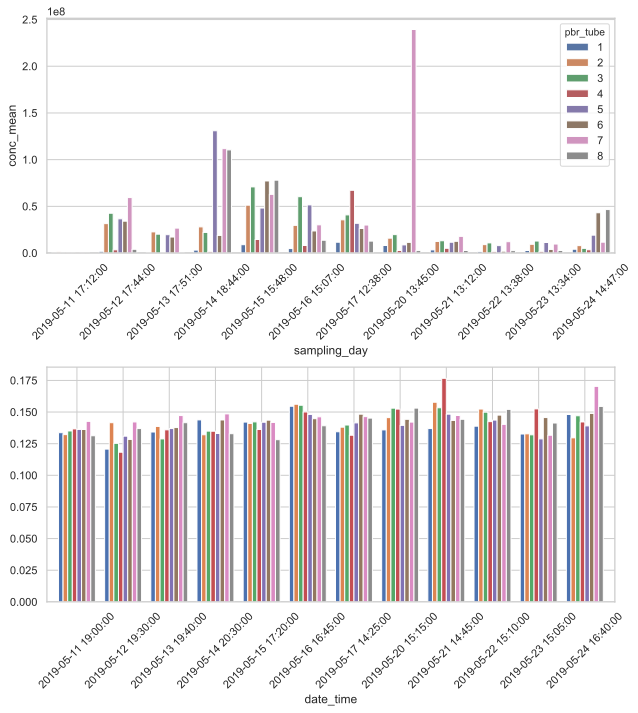

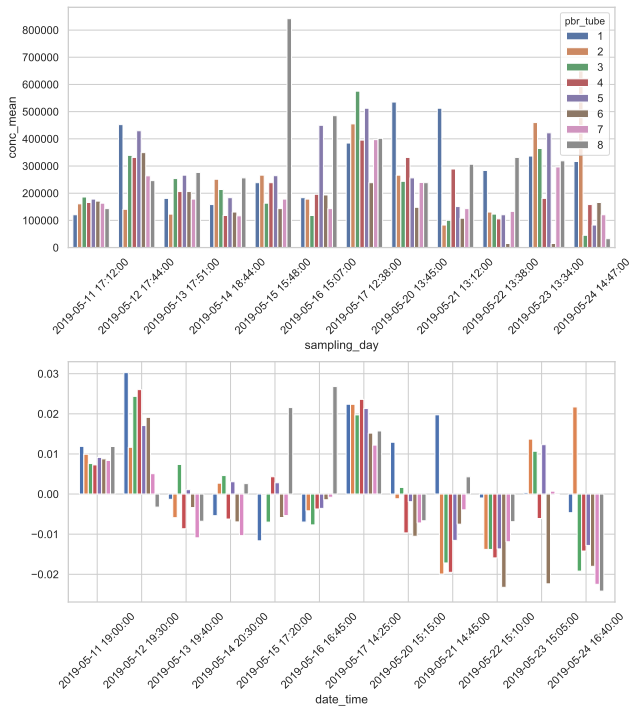

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=fs)

sns.barplot(data=x3_cell_counts[0], y='conc_mean',x='sampling_day', hue='pbr_tube', ax=ax[0])
ax[0].set_xticklabels(x3_cell_counts[0].index.unique(), rotation=45)

x3_B_p.plot(kind='bar', legend=False, style='.', width=0.8, ax=ax[1])
ax[1].set_xticklabels(x3_B_p.index.unique(), rotation=45)
plt.tight_layout()




fig, ax = plt.subplots(nrows=2, ncols=1, figsize=fs)

sns.barplot(data=x3_cell_counts[1], y='conc_mean',x='sampling_day', hue='pbr_tube', ax=ax[0])
ax[0].set_xticklabels(x3_cell_counts[1].index.unique(), rotation=45)

x3_C_p.plot(kind='bar', legend=False, style='.', width=0.8, ax=ax[1])
ax[1].set_xticklabels(x3_C_p.index.unique(), rotation=45)
plt.tight_layout()

# Correlation Analysis :

    What I'm trying to do here is to correlate the cell_counts data against the predicted values
    of the OLD single strain models. I was hopeful that there would be some correlation here, but
    by the looks of it this wont be the case. A good correlation would have allowed me to regress
    back to cell counts from absorbance (680,720) which would provide a more intuitive informant
    as to what is truely in our vessesl. 
    
    The reason for this was that previously I did hot have calibration to obtain this same model.
    However now we do have that data.
    
    ToDo:
        Use old models to construct pred-to-cc calibration models
        Use new models to construct pred-to-cc calibration model
        
        ----compare the above two against each other---
        ----compare the above two aginst:
        Use new data to build abs-to-pred-to-cc calibration model
        

    It does not look like the regression would provide anything meaningful, its as if nothing was
    captured at those wavelengths using the tecan, but we still need to check those days values
    against the actual measured values at the pbr
    
    
    

# Skip Code Below
    
    Instead use the new data to arrive at cell counts from abs-to-cellcounts

In [27]:
# process dataframe to match tecan df
%config InteractiveShell.ast_node_interactivity='all'

x2_B_counts = x2_cell_counts[0]
x2_C_counts = x2_cell_counts[1]

x3_B_counts = x3_cell_counts[0]
x3_C_counts = x3_cell_counts[1]

dflst = []
for name, group in x2_B_counts.groupby('sampling_day'):
    group = group.reset_index()
    group['date_time'] = group['date_time'].astype(str)
    idx = group['date_time'].unique()
    tdf = pd.DataFrame(group[['conc_mean']].values.transpose(), index=idx)
    tdf.columns = tdf.columns+1
    
    tdf.columns = 'T'+tdf.columns.astype(str)
    tdf.index.name = 'date_time'
    dflst.append(tdf)

x2_B_c = pd.concat(dflst)

dflst = []
for name, group in x2_C_counts.groupby('sampling_day'):
    group = group.reset_index()
    group['date_time'] = group['date_time'].astype(str)
    idx = group['date_time'].unique()
    tdf = pd.DataFrame(group[['conc_mean']].values.transpose(), index=idx)
    tdf.columns = tdf.columns+1
    
    tdf.columns = 'T'+tdf.columns.astype(str)
    tdf.index.name = 'date_time'
    dflst.append(tdf)

x2_C_c = pd.concat(dflst)


dflst = []
for name, group in x3_B_counts.groupby('sampling_day'):
    group = group.reset_index()
    group['date_time'] = group['date_time'].astype(str)
    idx = group['date_time'].unique()
    tdf = pd.DataFrame(group[['conc_mean']].values.transpose(), index=idx)
    tdf.columns = tdf.columns+1
    
    tdf.columns = 'T'+tdf.columns.astype(str)
    tdf.index.name = 'date_time'
    dflst.append(tdf)

x3_B_c = pd.concat(dflst)


dflst = []
for name, group in x3_C_counts.groupby('sampling_day'):
    group = group.reset_index()
    group['date_time'] = group['date_time'].astype(str)
    idx = group['date_time'].unique()
    tdf = pd.DataFrame(group[['conc_mean']].values.transpose(), index=idx)
    tdf.columns = tdf.columns+1
    
    tdf.columns = 'T'+tdf.columns.astype(str)
    tdf.index.name = 'date_time'
    dflst.append(tdf)

x3_C_c = pd.concat(dflst)

In [28]:
x2_B_c.head()
x2_B_p.head()

,T1,T2,T3,T4,T5,T6,T7,T8
date_time,,,,,,,,
2019-04-17 19:42:00,2.429613e+06,2.237978e+06,2.691604e+06,3.887649e+06,3.643749e+06,3.397170e+05,9.313740e+05,4.422351e+05
2019-04-18 15:54:00,1.974158e+08,1.836750e+08,2.510247e+08,2.350138e+08,4.060858e+08,7.303580e+06,8.010486e+06,6.623476e+06
2019-04-19 10:37:00,2.337112e+08,2.175428e+08,5.734818e+08,4.320470e+08,5.713879e+08,1.631245e+07,4.355346e+06,1.943154e+07
2019-04-20 14:58:00,1.386474e+08,1.035433e+08,4.516628e+08,2.921482e+08,9.762340e+07,4.288341e+05,1.611478e+07,9.343892e+06
2019-04-21 18:09:00,1.529731e+08,1.253167e+08,3.051808e+08,1.700846e+08,3.252941e+08,1.698250e+07,1.395721e+07,1.021999e+07


,T1B_p680_730_560,T2B_p680_730_560,T3B_p680_730_560,T4B_p680_730_560,T5B_p680_730_560,T6B_p680_730_560,T7B_p680_730_560,T8B_p680_730_560
date_time,,,,,,,,
2019-04-17 20:55:00,0.141425,0.139366,0.142420,0.146957,0.144833,0.147302,0.145820,0.134066
2019-04-18 17:25:00,0.250211,0.270634,0.258686,0.261788,0.269506,0.141084,0.143023,0.137578
2019-04-19 12:25:00,0.180053,0.188924,0.250466,0.228487,0.249617,0.127078,0.135463,0.123283
2019-04-20 16:40:00,0.182193,0.175748,0.223406,0.195503,0.217309,0.138203,0.142132,0.121158
2019-04-21 19:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exp2

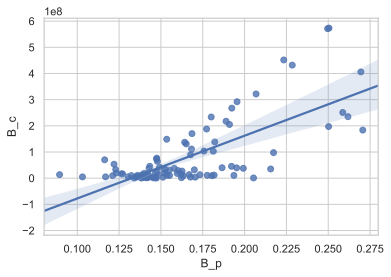

In [29]:
%config InteractiveShell.ast_node_interactivity='last'



tdf = pd.DataFrame()
tdf['B_c'] = None
tdf['B_p'] = None
for i in range(8):
    #print('tube_'+str(i))
    tmp = pd.DataFrame()
    data = x2_B_c.iloc[:,i].values, x2_B_p.iloc[:,i].values
    tmp['B_c'] = pd.Series(data[0])
    tmp['B_p'] = pd.Series(data[1])
    tdf = pd.concat([tdf, tmp]).reset_index(drop=True)
    
sns.regplot(data=tdf, x='B_p', y='B_c')

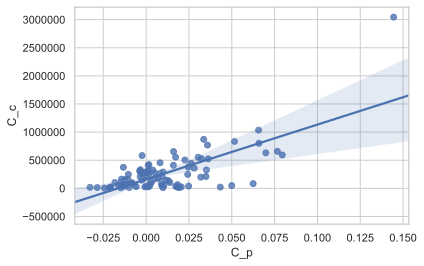

In [30]:
# for a given pair of values itert
tdf = pd.DataFrame()
tdf['C_c'] = None
tdf['C_p'] = None
for i in range(8):
    #print('tube_'+str(i))
    tmp = pd.DataFrame()
    data = x2_C_c.iloc[:,i].values, x2_C_p.iloc[:,i].values
    tmp['C_c'] = pd.Series(data[0])
    tmp['C_p'] = pd.Series(data[1])
    tdf = pd.concat([tdf, tmp]).reset_index(drop=True)
tdf
sns.regplot(data=tdf, x='C_p', y='C_c')

# Exp 3

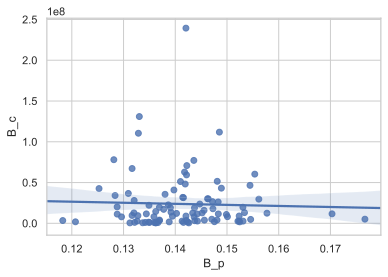

In [31]:
# for a given pair of values itert

tdf = pd.DataFrame()
tdf['B_c'] = None
tdf['B_p'] = None
for i in range(8):
    #print('tube_'+str(i))
    tmp = pd.DataFrame()
    data = x3_B_c.iloc[:,i].values, x3_B_p.iloc[:,i].values
    tmp['B_c'] = pd.Series(data[0])
    tmp['B_p'] = pd.Series(data[1])
    tdf = pd.concat([tdf, tmp]).reset_index(drop=True)
    
sns.regplot(data=tdf, x='B_p', y='B_c')

tube_0
tube_1
tube_2
tube_3
tube_4
tube_5
tube_6
tube_7


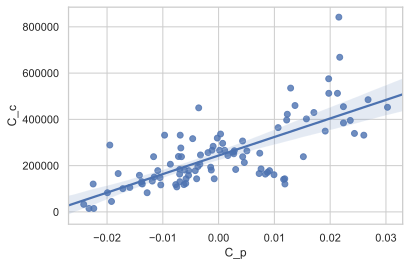

In [32]:
# for a given pair of values itert
tdf = pd.DataFrame()
tdf['C_c'] = None
tdf['C_p'] = None
for i in range(8):
    print('tube_'+str(i))
    tmp = pd.DataFrame()
    data = x3_C_c.iloc[:,i].values, x3_C_p.iloc[:,i].values
    tmp['C_c'] = pd.Series(data[0])
    tmp['C_p'] = pd.Series(data[1])
    tdf = pd.concat([tdf, tmp]).reset_index(drop=True)
tdf
sns.regplot(data=tdf, x='C_p', y='C_c')


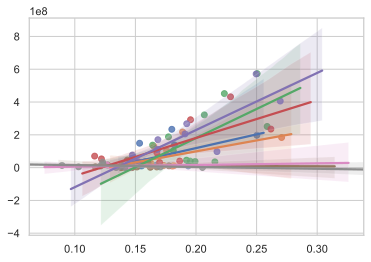

In [33]:
for i in range(8):
    #print('tube_'+str(i))
    data = x2_B_c.iloc[:,i].values, x2_B_p.iloc[:,i].values
    sns.regplot(x=data[1], y=data[0])

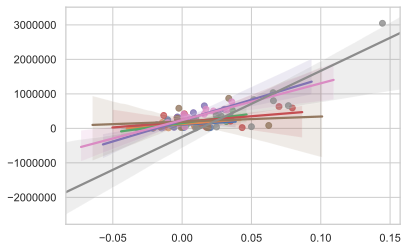

In [34]:
for i in range(8):
    #print('tube_'+str(i))
    data = x2_C_c.iloc[:,i].values, x2_C_p.iloc[:,i].values
    sns.regplot(x=data[1], y=data[0])
    

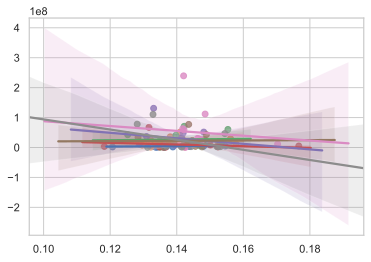

In [35]:
for i in range(8):
    #print('tube_'+str(i))
    data = x3_B_c.iloc[:,i].values, x3_B_p.iloc[:,i].values
    sns.regplot(x=data[1], y=data[0])

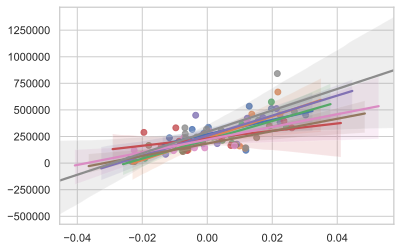

In [36]:
for i in range(8):
    #print('tube_'+str(i))
    data = x3_C_c.iloc[:,i].values, x3_C_p.iloc[:,i].values
    sns.regplot(x=data[1], y=data[0])